# Textual Inversion の実装

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/py-img-gen/python-image-generation/blob/main/notebooks/5-1-1_textual-inversion.ipynb)

参考: https://huggingface.co/docs/diffusers/en/training/text_inversion

## 準備

In [ ]:
!pip install -qq py-img-gen

In [1]:
import diffusers

diffusers.utils.logging.set_verbosity_error()

In [2]:
model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
resize_size = 512

In [3]:
import pathlib

current_dir = pathlib.Path.cwd()
project_dir = current_dir / "data" / "textual-inversion"
project_dir.mkdir(exist_ok=True, parents=True)
print(f"Created a directory: {project_dir}")

Created a directory: /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/textual-inversion


In [4]:
sample_image_dir = project_dir / "sample-images"
sample_image_dir.mkdir(exist_ok=True, parents=True)
print(f"Created a directory: {sample_image_dir}")

Created a directory: /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/textual-inversion/sample-images


In [5]:
sd_concept_dir = project_dir / "sd-concept-output"

In [6]:
from diffusers.utils import load_image
from tqdm.auto import tqdm

image_file_paths = [
    "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/1.jpeg",
    "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/2.jpeg",
    "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/3.jpeg",
    "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/4.jpeg",
]

for i, path in enumerate(tqdm(image_file_paths)):
    image = load_image(path)
    image = image.resize((resize_size, resize_size))
    image_filepath = sample_image_dir / f"{i}.png"
    print(f"Saving the image to {image_filepath}")
    image.save(image_filepath)

  0%|          | 0/4 [00:00<?, ?it/s]

Saving the image to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/textual-inversion/sample-images/0.png
Saving the image to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/textual-inversion/sample-images/1.png
Saving the image to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/textual-inversion/sample-images/2.png
Saving the image to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/textual-inversion/sample-images/3.png


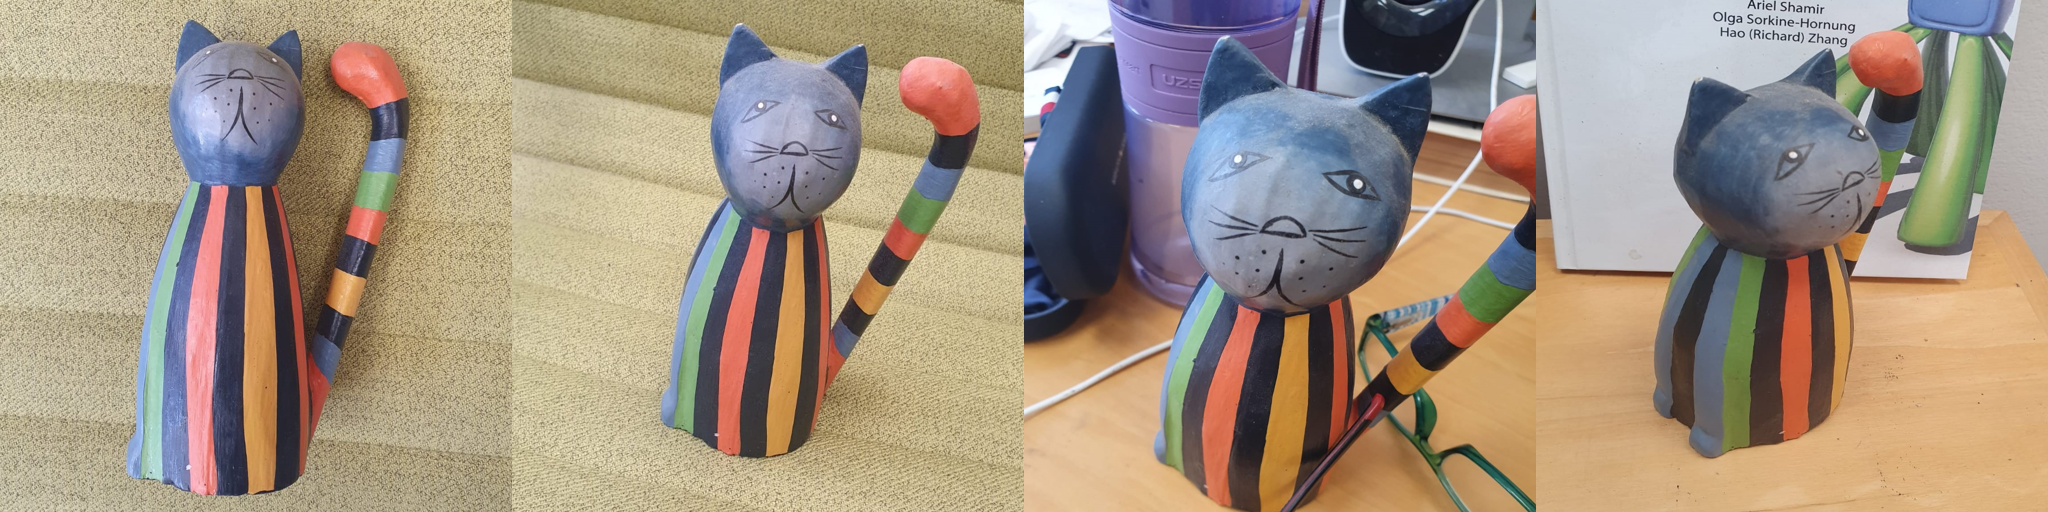

In [7]:
from diffusers.utils import make_image_grid

images = [
    load_image(str(path))
    for path in sample_image_dir.glob("*.png")
]
make_image_grid(images, rows=1, cols=len(images))

In [8]:
from typing import Literal, get_args

# モデルに教える特性の選択肢を定義します。ここでは object と style が選択可能
LearnableProperty = Literal["object", "style"]

# モデルに何を教えるかを指定
what_to_teach: LearnableProperty = "object"

# 新しい概念を表現するために使用するトークンを指定
placeholder_token = "<cat-toy>"

# 新しい概念に関連する単語を指定
initializer_token = (
    "toy"  # 今回の場合は cat でもいいかもしれません
)

# `what_to_teach` を正しく設定できているか確認します
if what_to_teach not in get_args(LearnableProperty):
    raise ValueError(
        f"Invalid learnable property: {what_to_teach}. "
        f"You should choose from the following options: {get_args(LearnableProperty)}."
    )

In [9]:
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

In [10]:
from dataclasses import dataclass


@dataclass
class Hyperparameter(object):
    learning_rate: float = 5.0e-04
    is_scale_lr: bool = True
    max_train_steps: int = 1000
    save_steps: int = 250
    train_batch_size: int = 16
    image_repeats: int = 100
    gradient_accumulation_steps: int = 1
    gradient_checkpointing: bool = True
    mixed_precision: str = "fp16"
    seed: int = 19950815
    output_dir_path: pathlib.Path = sd_concept_dir


hparams = Hyperparameter()
print(hparams)

print(
    f"The training results are saved in the following directory: {hparams.output_dir_path}"
)
hparams.output_dir_path.mkdir(exist_ok=True, parents=True)

Hyperparameter(learning_rate=0.0005, is_scale_lr=True, max_train_steps=1000, save_steps=250, train_batch_size=16, image_repeats=100, gradient_accumulation_steps=1, gradient_checkpointing=True, mixed_precision='fp16', seed=19950815, output_dir_path=PosixPath('/root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/textual-inversion/sd-concept-output'))
The training results are saved in the following directory: /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/textual-inversion/sd-concept-output


In [11]:
import random
from typing import Dict, List, Optional, TypedDict

import numpy as np
import torch
from diffusers.utils import PIL_INTERPOLATION
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import RandomHorizontalFlip
from transformers import CLIPTokenizer

InterpolationType = Literal[
    "linear", "bilinear", "bicubic", "lanczos", "nearest"
]


class Example(TypedDict):
    input_ids: torch.Tensor
    pixel_values: torch.Tensor


@dataclass
class TextualInversionDataset(Dataset):
    data_root: pathlib.Path
    tokenizer: CLIPTokenizer
    placeholder_token: str
    learnable_property: LearnableProperty = "object"
    image_size: int = 512
    repeats: int = 100
    interpolation_type: InterpolationType = "bicubic"
    flip_proba: float = 0.5
    split: str = "train"
    is_center_crop: bool = False

    _image_paths: Optional[List[pathlib.Path]] = None

    def __post_init__(self) -> None:
        assert self.data_root.exists()
        self._image_paths = [
            p
            for p in self.data_root.iterdir()
            if p.is_file()
        ]

    @property
    def image_paths(self) -> List[pathlib.Path]:
        assert self._image_paths is not None
        return self._image_paths

    @property
    def num_images(self) -> int:
        return len(self.image_paths)

    @property
    def dataset_length(self) -> int:
        return (
            self.num_images * self.repeats
            if self.split == "train"
            else self.num_images
        )

    @property
    def interpolation(self) -> int:
        return PIL_INTERPOLATION[self.interpolation_type]

    @property
    def templates(self) -> List[str]:
        return (
            imagenet_style_templates_small
            if self.learnable_property == "style"
            else imagenet_templates_small
        )

    @property
    def flip_transform(self) -> RandomHorizontalFlip:
        return RandomHorizontalFlip(p=self.flip_proba)

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Example:
        #
        # 入力画像に対する処理
        #
        img_path = self.image_paths[idx % self.num_images]
        img_pil = load_image(str(img_path))
        img_arr = np.array(img_pil).astype(np.uint8)

        if self.is_center_crop:
            crop = min(*img_arr.shape)
            h, w = img_arr.shape[:1]
            img_arr = img_arr[
                (h - crop) // 2 : (h + crop) // 2,
                (w - crop) // 2 : (w + crop) // 2,
            ]

        # 画像のリサイズと水平反転を行い、[-1, 1] の範囲に正規化
        img_pil = Image.fromarray(img_arr)
        img_pil = img_pil.resize(
            (self.image_size, self.image_size),
            resample=self.interpolation,
        )
        img_pil = self.flip_transform(img_pil)
        img_arr = np.array(img_pil).astype(np.uint8)
        img_arr = (img_arr / 127.5 - 1.0).astype(np.float32)

        # ピクセル値をテンソルに変換し、次元の順番を変更
        pixel_values = torch.from_numpy(img_arr).permute(
            2, 0, 1
        )

        #
        # プロンプトテキストに対する処理
        #
        # 上記で定義したプロンプトのテンプレートリストからランダムに
        # 1 つ取ってきて、placeholder_token を埋め込む
        template = random.choice(self.templates)
        text = template.format(self.placeholder_token)

        # tokenizer で文章をトークン列に変換
        (input_ids,) = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids

        return {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
        }

In [12]:
from transformers import CLIPTokenizer

# tokenizer の読み込み
tokenizer = CLIPTokenizer.from_pretrained(
    model_id, subfolder="tokenizer"
)

# `placeholder_token` と tokenizer に追加
num_added_tokens = tokenizer.add_tokens(placeholder_token)

if num_added_tokens == 0:
    # `placeholder_token` が元々 `tokenizer` に含まれていたらエラーを出す
    # エラーになったら違う `placeholder_token` を指定するようにしてください
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. ",
        "Please pass a difference `placeholder_token` that is not already in the tokenizer.",
    )

In [13]:
token_ids = tokenizer.encode(
    initializer_token, add_special_tokens=False
)
if len(token_ids) > 1:
    raise ValueError(
        "The initializer token must be a single token."
    )

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(
    placeholder_token
)

In [14]:
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTextModel

text_encoder = CLIPTextModel.from_pretrained(
    model_id,
    subfolder="text_encoder",
)
assert isinstance(text_encoder, CLIPTextModel)

vae = AutoencoderKL.from_pretrained(
    model_id,
    subfolder="vae",
)
assert isinstance(vae, AutoencoderKL)

unet = UNet2DConditionModel.from_pretrained(
    model_id,
    subfolder="unet",
)
assert isinstance(unet, UNet2DConditionModel)

In [15]:
# 新しい特殊トークンをトークナイザに追加しているため、それに合わせてトークン埋め込みをリサイズ
text_encoder.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(49409, 768)

In [16]:
token_embeds = (
    text_encoder.get_input_embeddings().weight.data
)

with torch.no_grad():
    init_embed = token_embeds[initializer_token_id].clone()
    token_embeds[placeholder_token_id] = init_embed

In [17]:
# vae と unet のパラメータを固定
vae.requires_grad_(False)
unet.requires_grad_(False)

# テキストエンコーダのトークン埋め込み以外のパラメータを固定
modules = (
    text_encoder.text_model.encoder,
    text_encoder.text_model.final_layer_norm,
    text_encoder.text_model.embeddings.position_embedding,
)
for m in modules:
    m.requires_grad_(False)

# GPU メモリの使用を抑える Gradient Checkpointing の設定
if hparams.gradient_checkpointing:
    unet.train()
    text_encoder.gradient_checkpointing_enable()
    unet.enable_gradient_checkpointing()

In [18]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler.from_pretrained(
    model_id,
    subfolder="scheduler",
)

In [19]:
from accelerate import Accelerator


def save_progress(
    text_encoder: CLIPTextModel,
    placeholder_token_id: int,
    accelerator: Accelerator,
    save_path: pathlib.Path,
) -> None:
    # 新たに追加した概念に対応する埋め込みベクトルのみを保存する
    # `placeholder_token` の ID を指定することで対象のベクトルを取得可能
    learned_embeds = (
        accelerator.unwrap_model(text_encoder)
        .get_input_embeddings()
        .weight[placeholder_token_id]
    )
    learned_embeds_dict = {
        placeholder_token: learned_embeds.clone()
        .detach()
        .cpu()
    }

    print(f"Saving the learned embeddings to {save_path}")
    torch.save(learned_embeds_dict, save_path)

In [20]:
import torch.nn.functional as F
from accelerate.utils import set_seed
from diffusers import StableDiffusionPipeline
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


def training_function(
    text_encoder: CLIPTextModel,
    vae: AutoencoderKL,
    unet: UNet2DConditionModel,
):
    # 学習の再現性を確保するために乱数の seed を固定
    set_seed(hparams.seed)

    # 学習を効率化する Accelerator の設定
    accelerator = Accelerator(
        gradient_accumulation_steps=hparams.gradient_accumulation_steps,
        mixed_precision=hparams.mixed_precision,
    )

    # 学習率をハイパーパラメータを考慮してスケーリングする
    learning_rate = (
        (
            hparams.learning_rate
            * hparams.gradient_accumulation_steps
            * hparams.train_batch_size
            * accelerator.num_processes
        )
        if hparams.is_scale_lr
        else hparams.learning_rate
    )
    # 最適化手法を初期化
    optimizer = torch.optim.AdamW(
        # 追加した placeholder_token の部分のみ学習
        params=text_encoder.get_input_embeddings().parameters(),
        lr=learning_rate,
    )

    # 学習用データセットの設定
    train_dataset = TextualInversionDataset(
        data_root=sample_image_dir,
        tokenizer=tokenizer,
        image_size=vae.config.sample_size,
        placeholder_token=placeholder_token,
        repeats=hparams.image_repeats,
        learnable_property=what_to_teach,
        is_center_crop=False,
        split="train",
    )

    # 学習用のデータローダーの設定
    train_data_loader = DataLoader(
        train_dataset,
        batch_size=hparams.train_batch_size,
        shuffle=True,
        num_workers=4,
    )

    # Accelerator でモジュールをラップ
    text_encoder, optimizer, train_data_loader = (
        accelerator.prepare(
            text_encoder, optimizer, train_data_loader
        )
    )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16
    else:
        raise ValueError(
            f"Invalid dtype: {accelerator.mixed_precision}"
        )

    # GPU へ VAE と U-Net を移動させます
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)

    # Text-Encoder は train モードに
    text_encoder.train()
    # VAE は学習させないため eval モードに
    vae.eval()

    # Train!
    total_batch_size = (
        hparams.train_batch_size
        * hparams.gradient_accumulation_steps
        * accelerator.num_processes
    )

    print("***** Running training *****")
    print(f"  Num examples = {len(train_dataset)}")
    print(
        f"  Instantaneous batch size per device = {hparams.train_batch_size}"
    )
    print(
        f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}"
    )
    print(
        f"  Grad. Accum. steps = {hparams.gradient_accumulation_steps}"
    )
    print(
        f"  Total optimization steps = {hparams.max_train_steps}"
    )

    progress_bar = tqdm(
        range(hparams.max_train_steps),
        disable=not accelerator.is_local_main_process,
    )
    progress_bar.set_description("Steps")

    global_step = 0
    train_data_iterator = iter(train_data_loader)

    # # 元の埋め込みを参照として保持
    # orig_embeds_params = (
    #     accelerator.unwrap_model(text_encoder)
    #     .get_input_embeddings()
    #     .weight.data.clone()
    # )

    while global_step != hparams.max_train_steps:
        try:
            batch = next(train_data_iterator)
        except StopIteration:
            train_data_iterator = iter(train_data_loader)
            batch = next(train_data_iterator)

        # テキストエンコーダが train モードになっていることを確認
        text_encoder.train()

        with accelerator.accumulate(text_encoder):
            loss = train_step(
                batch=batch,
                text_encoder=text_encoder,
                vae=vae,
                unet=unet,
                noise_scheduler=noise_scheduler,
                weight_dtype=weight_dtype,
                accelerator=accelerator,
                optimizer=optimizer,
            )

        # accelerator がバックグラウンドで最適化工程を実行したかを確認
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1

            if global_step % hparams.save_steps == 0:
                save_path = (
                    hparams.output_dir_path
                    / f"learned_embeds-step-{global_step}.bin"
                )
                save_progress(
                    text_encoder,
                    placeholder_token_id,
                    accelerator,
                    save_path,
                )

        logs = {"loss": loss.detach().item()}
        progress_bar.set_postfix(**logs)

        if global_step >= hparams.max_train_steps:
            break

    accelerator.wait_for_everyone()

    if accelerator.is_main_process:
        # 学習したモデルを元に、pipeline を構築して保存
        pipeline = StableDiffusionPipeline.from_pretrained(
            model_id,
            text_encoder=accelerator.unwrap_model(
                text_encoder
            ),
            tokenizer=tokenizer,
            vae=vae,
            unet=unet,
        )
        pipeline.save_pretrained(hparams.output_dir_path)

        # 新たに追加した概念に対応するパラメータも保存
        save_progress(
            # text_encoder, placeholder_token_id, accelerator, save_path,
            text_encoder=text_encoder,
            placeholder_token_id=placeholder_token_id,
            accelerator=accelerator,
            save_path=save_path,
        )


def train_step(
    batch: Dict[str, torch.Tensor],
    text_encoder: CLIPTextModel,
    vae: AutoencoderKL,
    unet: UNet2DConditionModel,
    noise_scheduler: DDPMScheduler,
    weight_dtype: torch.dtype,
    accelerator: Accelerator,
    optimizer: torch.optim.Optimizer,
) -> torch.Tensor:
    # 画像を潜在表現へ変換
    pixel_values = batch["pixel_values"].to(
        dtype=weight_dtype
    )
    latents = (
        vae.encode(pixel_values)
        .latent_dist.sample()
        .detach()
    )
    latents *= vae.config.scaling_factor

    # 潜在表現へ追加するノイズを取得
    noise = torch.randn_like(latents)
    bsz = latents.shape[0]
    # 各画像に対してランダムなタイムステップ数を取得
    timesteps = torch.randint(
        0,
        noise_scheduler.config.num_train_timesteps,
        (bsz,),
        device=latents.device,
    )
    timesteps = timesteps.long()

    # 各タイムステップにおけるノイズの大きさに従って
    # 潜在表現にノイズを追加（拡散過程）
    noisy_latents = noise_scheduler.add_noise(
        latents, noise, timesteps
    )

    # 条件付けのためにプロンプトからテキストベクトルを取得
    encoder_hidden_states = text_encoder(
        batch["input_ids"]
    ).last_hidden_state.to(dtype=weight_dtype)

    # ノイズを予測
    noise_pred = unet(
        noisy_latents, timesteps, encoder_hidden_states
    ).sample

    # 予測タイプに応じた損失を計算
    if noise_scheduler.config.prediction_type == "epsilon":
        target = noise
    elif (
        noise_scheduler.config.prediction_type
        == "v_prediction"
    ):
        target = noise_scheduler.get_velocity(
            latents, noise, timesteps
        )
    else:
        raise ValueError(
            f"Unknown prediction type {noise_scheduler.config.prediction_type}"
        )

    loss = F.mse_loss(
        noise_pred.float(), target.float(), reduction="mean"
    )
    accelerator.backward(loss)

    # 概念の埋め込みだけを最適化したいので、
    # 新しく追加された概念の埋め込み以外のすべてのトークンの埋め込みに対する勾配をゼロに
    grads = (
        text_encoder.module.get_input_embeddings().weight.grad
        if accelerator.num_processes > 1
        else text_encoder.get_input_embeddings().weight.grad
    )

    # 勾配をゼロにする対象のインデックスを取得
    # `placeholder_token_id` 以外のものを選択することで達成
    index_grads_to_zero = (
        torch.arange(len(tokenizer)) != placeholder_token_id
    )
    grads.data[index_grads_to_zero, :] = grads.data[
        index_grads_to_zero, :
    ].fill_(0)

    optimizer.step()
    optimizer.zero_grad()

    return loss

In [21]:
import itertools

import accelerate

accelerate.notebook_launcher(
    training_function,
    args=(text_encoder, vae, unet),
    num_processes=1,
)

for param in itertools.chain(
    unet.parameters(), text_encoder.parameters()
):
    if param.grad is not None:
        # Colab では RAM の制約があるため勾配に関する情報を削除
        del param.grad
    torch.cuda.empty_cache()

Launching training on one GPU.
***** Running training *****
  Num examples = 400
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Grad. Accum. steps = 1
  Total optimization steps = 1000


  0%|          | 0/1000 [00:00<?, ?it/s]

Saving the learned embeddings to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/textual-inversion/sd-concept-output/learned_embeds-step-250.bin
Saving the learned embeddings to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/textual-inversion/sd-concept-output/learned_embeds-step-500.bin
Saving the learned embeddings to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/textual-inversion/sd-concept-output/learned_embeds-step-750.bin
Saving the learned embeddings to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/textual-inversion/sd-concept-output/learned_embeds-step-1000.bin


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Saving the learned embeddings to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/textual-inversion/sd-concept-output/learned_embeds-step-1000.bin


In [22]:
from diffusers import DPMSolverMultistepScheduler

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

scheduler = DPMSolverMultistepScheduler.from_pretrained(
    hparams.output_dir_path, subfolder="scheduler"
)

pipe = StableDiffusionPipeline.from_pretrained(
    hparams.output_dir_path,
    scheduler=scheduler,
    torch_dtype=torch.float16,
)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

A <cat-toy> backpack


  0%|          | 0/25 [00:00<?, ?it/s]

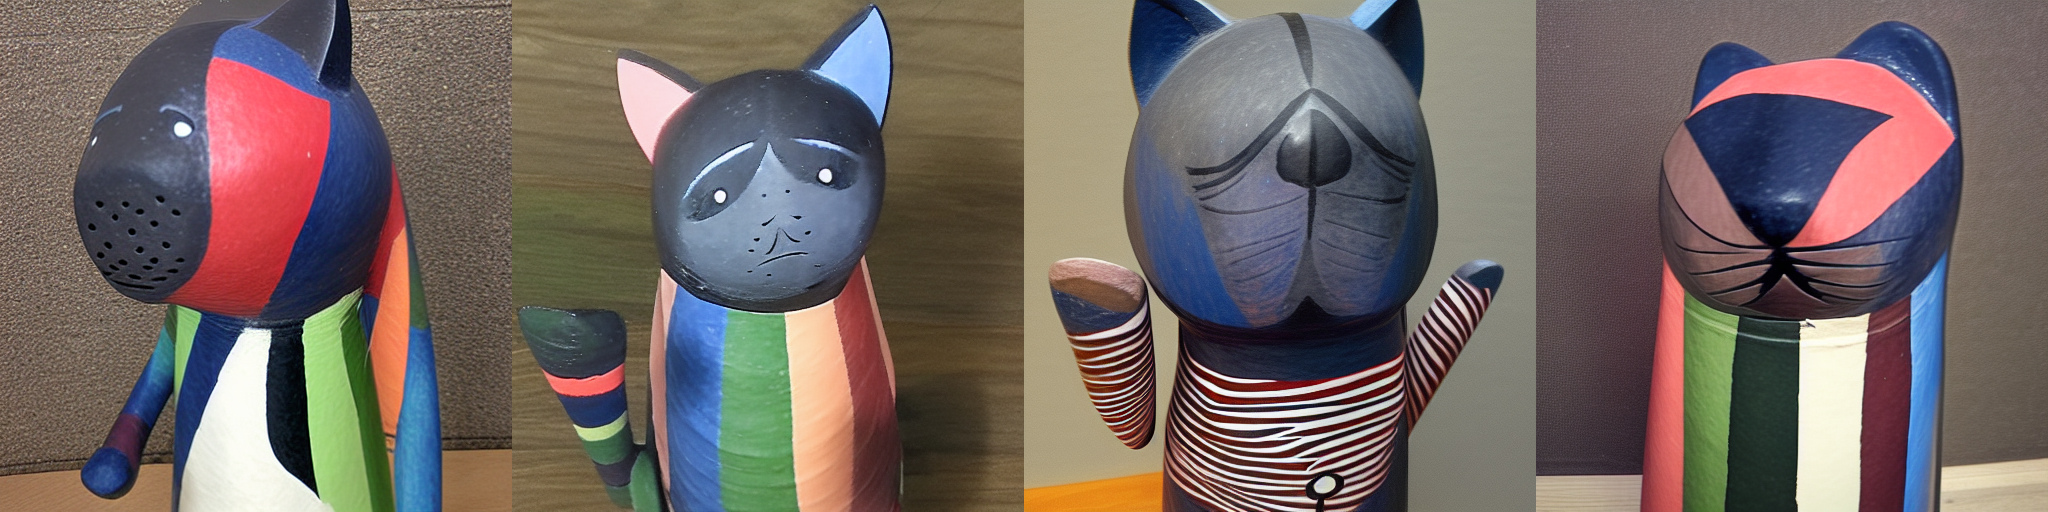

In [23]:
prompt = f"A {placeholder_token} backpack"
print(prompt)

output = pipe(
    prompt=prompt,
    num_images_per_prompt=4,
    generator=torch.manual_seed(hparams.seed),
    num_inference_steps=25,
)
images = output.images
make_image_grid(images=images, rows=1, cols=len(images))